In [1]:
%load_ext autoreload
%autoreload 2

from timeit import default_timer as timer
import sys

sys.path.insert(0, "python")

from estimagic.optimization.optimize import maximize
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numdifftools as nd
import pandas as pd
import respy as rp
import numpy as np

from calibration_maximum_likelihood import get_bootstrap_sample
from calibration_maximum_likelihood import run_bootstrap
from auxiliary import plot_bootstrap_distribution
from auxiliary import plot_computational_budget
from auxiliary import plot_smoothing_parameter
from auxiliary import plot_profile_likelihood
from auxiliary import plot_score_distribution
from auxiliary import plot_score_function

warnings.simplefilter(action="ignore", category=RuntimeWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Maximum likelihood estimation


* likelihood function

* score function and statistic

    * asymptotic distribution
    * linearity
    
* confidence intervals

    * Wald
    * likelihood - based
    * Bootstrap
    
    
* numerical approximations

    * smoothing of choice probabilities
    * grid search


Most of the material is from the following two references:

* Pawitan, Y. (2001). [In all likelihood: Statistical modelling and inference using likelihood](https://www.amazon.de/dp/0199671222/ref=sr_1_1?keywords=in+all+likelihood&qid=1573806115&sr=8-1). Clarendon Press, Oxford.

* Casella, G., & Berger, R. L. (2002). [Statistical inference](https://www.amazon.de/dp/0534243126/ref=sr_1_1?keywords=casella+berger&qid=1573806129&sr=8-1). Duxbury, Belmont, CA.

Let's get started!

In [32]:
options_base = yaml.safe_load(open(os.environ["ROBINSON_SPEC"] + '/robinson.yaml', 'r'))

params_base = pd.read_csv(open(os.environ["ROBINSON_SPEC"] + '/robinson.csv', 'r'))
params_base.set_index(["category", "name"], inplace=True)

simulate = rp.get_simulate_func(params_base, options_base)
df = simulate(params_base)

Let us briefly inspect the parameterization.

In [3]:
params_base

value
category       name                       
delta          delta                 0.950
wage_fishing   exp_fishing           0.070
nonpec_fishing constant             -0.100
nonpec_hammock constant              1.046
shocks_sdcorr  sd_fishing            0.010
               sd_hammock            0.010
               corr_hammock_fishing  0.000

Several options need to be specified as well.

In [4]:
options_base

{'estimation_draws': 100,
 'estimation_seed': 100,
 'estimation_tau': 0.001,
 'interpolation_points': -1,
 'n_periods': 5,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'solution_draws': 100,
 'solution_seed': 456,
 'covariates': {'constant': '1'}}

We can now look at the simulated dataset.

In [5]:
df.head()

Experience_Fishing  Shock_Reward_Fishing  \
Identifier Period                                             
0          0                        0              1.007197   
           1                        1              0.981015   
           2                        2              0.998980   
           3                        3              0.989253   
           4                        4              1.010431   

                   Meas_Error_Wage_Fishing  Shock_Reward_Hammock  \
Identifier Period                                                  
0          0                             1              0.010305   
           1                             1              0.010596   
           2                             1             -0.003797   
           3                             1             -0.011702   
           4                             1             -0.002176   

                   Meas_Error_Wage_Hammock   Choice      Wage  Discount_Rate  \
Identifier Period                                                              
0          0                             1  fishing  1.007197           0.95   
           1                             1  fishing  1.052147           0.95   
           2                             1  fishing  1.149101           0.95   
           3                             1  fishing  1.220419           0.95   
           4                             1  fishing  1.336932           0.95   

                   Nonpecuniary_Reward_Fishing  Wage_Fishing  \
Identifier Period                                              
0          0                              -0.1      1.007197   
           1                              -0.1      1.052147   
           2                              -0.1      1.149101   
           3                              -0.1      1.220419   
           4                              -0.1      1.336932   

                   Flow_Utility_Fishing  Value_Function_Fishing  \
Identifier Period                                                 
0          0                   0.907197                4.747606   
           1                   0.952147                4.022193   
           2                   1.049101                3.230306   
           3                   1.120419                2.282845   
           4                   1.236932                1.236932   

                   Continuation_Value_Fishing  Nonpecuniary_Reward_Hammock  \
Identifier Period                                                            
0          0                         4.042536                        1.046   
           1                         3.231627                        1.046   
           2                         2.296006                        1.046   
           3                         1.223607                        1.046   
           4                         0.000000                        1.046   

                   Wage_Hammock  Flow_Utility_Hammock  Value_Function_Hammock  \
Identifier Period                                                               
0          0                NaN              1.056305                4.742931   
           1                NaN              1.056596                3.903085   
           2                NaN              1.042203                3.063422   
           3                NaN              1.034298                2.111715   
           4                NaN              1.043824                1.043824   

                   Continuation_Value_Hammock  
Identifier Period                              
0          0                         3.880659  
           1                         2.996304  
           2                         2.127598  
           3                         1.134123  
           4                         0.000000

## Likelihood function

We can now start exploring the likelihood function. The likelihood function is a measure of information about the potentially unknown parameters of the model. The information will usually be incomplete and the likelihood function also expresses the degree of incompleteness.

We will usually work with the sum of the individual log-likelihoods throughout as the likelihood cannot be represented without raising problems of numerical overflow. Note that the criterion function of the ``respy`` package returns to the average log-likelihood across the sample. Thus, we need to be careful with scaling it up when computing some of the test statistics later in the notebook.

### Profile likelihood

We will first trace out the profile likelihood over reasonable parameter values. 

In [6]:
params_base["lower"] = [0.948, 0.0695, -0.11, 1.04, 0.0030, 0.005, -0.10]
params_base["upper"] = [0.952, 0.0705, -0.09, 1.05, 0.1000, 0.015, +0.10]

We plot the normalized likelihood, i.e. set the maximum of the likelihood function to one by dividing it by its maximum. 

In [7]:
crit_func = rp.get_crit_func(params_base, options_base, df)

rslts = dict()
for index in params_base.index:

    upper, lower = params_base.loc[index][["upper", "lower"]]
    grid = np.linspace(lower, upper, 20)

    fvals = list()
    for value in grid:
        params = params_base.copy()
        params.loc[index, "value"] = value
        fval = options_base["simulation_agents"] * crit_func(params)
        fvals.append(fval)

    rslts[index] = fvals

Let's visualize the results.

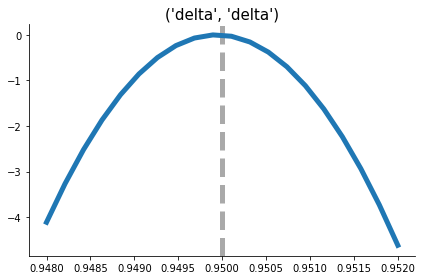

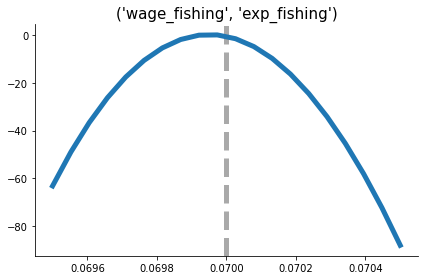

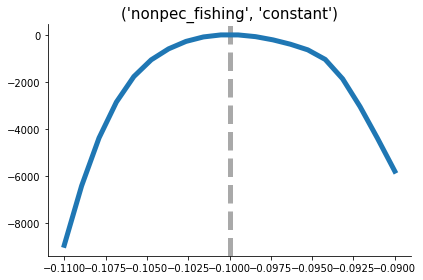

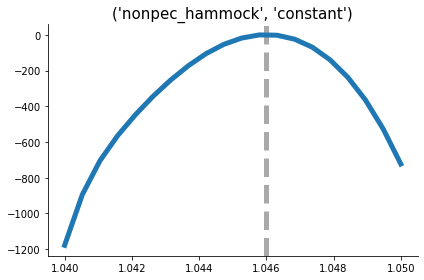

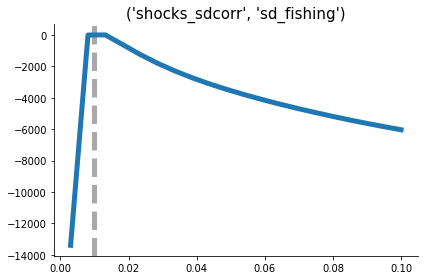

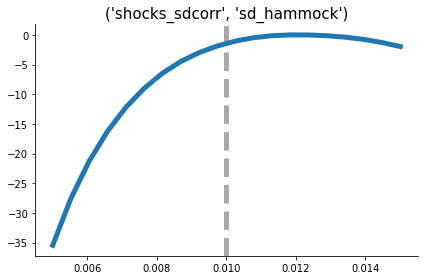

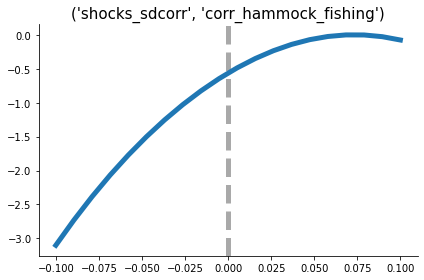

In [8]:
plot_profile_likelihood(rslts, params_base)

## Maximum likelihood estimate

So far, we looked at the likelihood function in its entirety. Going forward, we will take a narrower view and just focus on the maximum likelihood estimate. We restrict our attention to the discount factor $\delta$ and treat it as the only unknown parameter. We will use [estimagic](https://estimagic.readthedocs.io/) for all our estimations. 

In [9]:
crit_func = rp.get_crit_func(params_base, options_base, df)

However, we will make our life even easier and fix all parameters but the discount factor $\delta$.

In [10]:
constr_base = [
    {"loc": "shocks_sdcorr", "type": "fixed"}, 
    {"loc": "wage_fishing", "type": "fixed"},
    {"loc": "nonpec_fishing", "type": "fixed"},
    {"loc": "nonpec_hammock", "type": "fixed"}
]

We will start the estimation with a perturbation of the true value.

In [11]:
params_start = params_base.copy()
params_start.loc[("delta", "delta"), "value"] = 0.91

Now we are ready to deal with the selection and specification of the optimization algorithm.

In [12]:
algo_options = {"maxeval": 100}
algo_name = "nlopt_bobyqa"

results, params_rslt = maximize(crit_func, params_base, algo_name, algo_options=algo_options, constraints=constr_base)

Let's look at the results.

In [13]:
params_rslt

value   lower   upper           group  \
category       name                                                             
delta          delta                 0.949937  0.9480  0.9520  All Parameters   
wage_fishing   exp_fishing           0.070000  0.0695  0.0705  All Parameters   
nonpec_fishing constant             -0.100000 -0.1100 -0.0900  All Parameters   
nonpec_hammock constant              1.046000  1.0400  1.0500  All Parameters   
shocks_sdcorr  sd_fishing            0.010000  0.0030  0.1000  All Parameters   
               sd_hammock            0.010000  0.0050  0.0150  All Parameters   
               corr_hammock_fishing  0.000000 -0.1000  0.1000  All Parameters   

                                                                   name  \
category       name                                                       
delta          delta                                        delta_delta   
wage_fishing   exp_fishing                     wage_fishing_exp_fishing   
nonpec_fishing constant                         nonpec_fishing_constant   
nonpec_hammock constant                         nonpec_hammock_constant   
shocks_sdcorr  sd_fishing                      shocks_sdcorr_sd_fishing   
               sd_hammock                      shocks_sdcorr_sd_hammock   
               corr_hammock_fishing  shocks_sdcorr_corr_hammock_fishing   

                                     _fixed_value  _is_fixed_to_value  \
category       name                                                     
delta          delta                          NaN               False   
wage_fishing   exp_fishing                  0.070                True   
nonpec_fishing constant                    -0.100                True   
nonpec_hammock constant                     1.046                True   
shocks_sdcorr  sd_fishing                   0.010                True   
               sd_hammock                   0.010                True   
               corr_hammock_fishing         0.000                True   

                                     _post_replacements  _is_fixed_to_other  \
category       name                                                           
delta          delta                                 -1               False   
wage_fishing   exp_fishing                           -1               False   
nonpec_fishing constant                              -1               False   
nonpec_hammock constant                              -1               False   
shocks_sdcorr  sd_fishing                            -1               False   
               sd_hammock                            -1               False   
               corr_hammock_fishing                  -1               False   

                                     _internal_lower  _internal_upper  \
category       name                                                     
delta          delta                          0.9480           0.9520   
wage_fishing   exp_fishing                    0.0695           0.0705   
nonpec_fishing constant                      -0.1100          -0.0900   
nonpec_hammock constant                       1.0400           1.0500   
shocks_sdcorr  sd_fishing                     0.0030           0.1000   
               sd_hammock                     0.0050           0.0150   
               corr_hammock_fishing          -0.1000           0.1000   

                                     _internal_free  _pre_replacements  \
category       name                                                      
delta          delta                           True                  0   
wage_fishing   exp_fishing                    False                 -1   
nonpec_fishing constant                       False                 -1   
nonpec_hammock constant                       False                 -1   
shocks_sdcorr  sd_fishing                     False                 -1   
               sd_hammock                     False                 -1   
              

In [14]:
fval = results["fitness"] * options_base["simulation_agents"]
print(f"criterion function at optimum {fval:5.3f}")

criterion function at optimum 10032.913


We need to set up a proper interface to use some other Python functionality going forward.

In [15]:
def wrapper_crit_func(crit_func, options_base, params_base, value):

    params = params_base.copy()
    params.loc["delta", "value"] = value

    return options_base["simulation_agents"] * crit_func(params)

p_wrapper_crit_func = partial(wrapper_crit_func, crit_func, options_base, params_base)

We need to use the MLE repeatedly going forward.

In [16]:
delta_hat = params_rslt.loc[("delta", "delta"), "value"]

At the maximum, the second derivative of the log-likelihood is negative and we define the observed Fisher information  as follows

\begin{align*}
I{\theta} \equiv -\frac{\partial^2 \log L(\theta)}{\partial^2 \theta}
\end{align*}

In [17]:
delta_fisher = -nd.Derivative(p_wrapper_crit_func, n=2)([delta_hat]) 

In [18]:
delta_fisher

2131635.7112217033

## Score statistic and Score function

The Score function is the first-derivative of the log-likelihood.

\begin{align*}
S(\theta) \equiv \frac{\partial \log L(\theta)}{\partial \theta}
\end{align*}


### Distribution

The asymptotic normality of the score statistic is of key importance in deriving the asymptotic normality of the maximum likelihood estimator. Here we simulate $1,000$ samples of $10,000$ individuals and compute the score function at the true values. I had to increase the number of simulated individuals as convergence to the asymptotic distribution just took way to long.

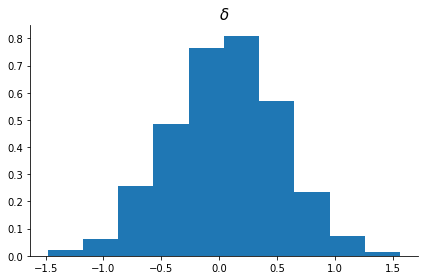

In [19]:
plot_score_distribution()

### Linearity

We need linearity of the score function around the true value so that the log-likelihood is reasonably well approximated by a second order Taylor-polynomial. 

\begin{align*}
\log L(\theta) \approx \log L(\hat{\theta}) + S(\hat{\theta})(\theta - \hat{\theta}) - \tfrac{1}{2} I(\hat{\theta}))(\theta - \hat{\theta})^2
\end{align*}

Since $S(\hat{\theta}) = 0$, we get:

\begin{align*}
\frac{\log L(\theta)}{\log L(\hat{\theta})}  \approx  \tfrac{1}{2} I(\hat{\theta}))(\theta - \hat{\theta})^2
\end{align*}

Taking the derivative to work with the score function, the following relationship is approximately true if the usual regularity conditions hold:

\begin{align*}
- I^{-1/2}(\hat{\theta}) S(\theta) \approx I^{-1/2}(\hat{\theta}) (\theta - \hat{\theta})
\end{align*}



In [20]:
num_points, index = 10, ("delta", "delta")

upper, lower = params_base.loc[index, ["upper", "lower"]]
grid = np.linspace(lower, upper, num_points)

fds = np.tile(np.nan, num_points)
for i, point in enumerate(grid):
    fds[i] = nd.Derivative(p_wrapper_crit_func, n=1)([point]) 

norm_fds = fds * - (1 / np.sqrt(delta_fisher))
norm_grid = (grid - delta_hat) *   (np.sqrt(delta_fisher))

In the best case we see a standard normal distribution of $I^{1/2} (\hat{\theta}) (\theta - \hat{\theta})$ and so it is common practice to evaluate the linearity over $-2$ and $2$.

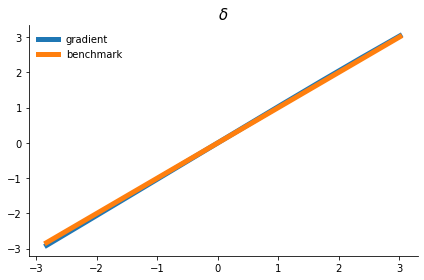

In [21]:
plot_score_function(norm_grid, norm_fds)

## Confidende intervals

### Wald intervals

In [22]:
rslt = list()
rslt.append(delta_hat - 1.96 * 1 / np.sqrt(delta_fisher))
rslt.append(delta_hat + 1.96 * 1 / np.sqrt(delta_fisher))
"{:5.3f} / {:5.3f}".format(*rslt)

'0.949 / 0.951'

### Likelihood-based intervals

The likelihood-based intervals do only rely on the asymptoric normality of the score function and not its linearity.

In [23]:
def root_wrapper(delta, options_base, alpha, index):
    
    crit_val = -0.5 * chi2.ppf(1 - alpha, 1)
    
    params_eval = params_base.copy()
    params_eval.loc[("delta", "delta"), "value"] = delta
    likl_ratio = options_base["simulation_agents"] * (crit_func(params_eval) - crit_func(params_base))
                      
    return likl_ratio - crit_val

In [24]:
brackets = [[0.75, 0.95], [0.95, 1.10]]

rslt = list()
for bracket in brackets:
    root = root_scalar(root_wrapper, method="bisect", bracket=bracket, args=(options_base, 0.05, index)).root
    rslt.append(root)
print("{:5.3f} / {:5.3f}".format(*rslt))

0.949 / 0.951


### Bootstrap

We can now run a simple bootstrap to see how the asymptotic standard errors line up.

Here are some useful resources on the topic:

* Davison, A., & Hinkley, D. (1997). [Bootstrap methods and their application](https://www.amazon.de/dp/B00D2WQ02U/ref=sr_1_1?keywords=bootstrap+methods+and+their+application&qid=1574070350&s=digital-text&sr=1-1). Cambridge University Press, Cambridge.

* Hesterberg, T. C. (2015). [What teachers should know about the bootstrap: Resampling in the undergraduate statistics curriculum](https://amstat.tandfonline.com/doi/full/10.1080/00031305.2015.1089789#.XdZhBldKjIV), *The American Statistician, 69*(4), 371-386.

* Horowitz, J. L. (2001). [Chapter 52. The bootstrap](https://www.scholars.northwestern.edu/en/publications/chapter-52-the-bootstrap). In Heckman, J.J., & Leamer, E.E., editors, *Handbook of Econometrics, 5*, 3159-3228. Elsevier Science B.V.

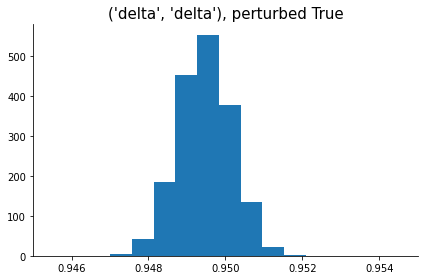

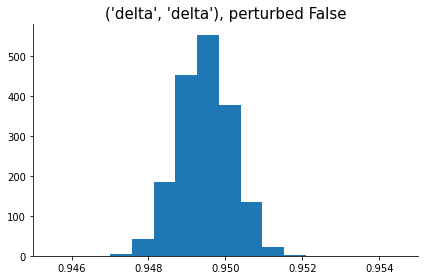

In [25]:
plot_bootstrap_distribution()

We can now construct the bootstrap confidence interval.

In [26]:
fname = "material/bootstrap.delta_perturb_true.pkl"
boot_params = pd.read_pickle(fname)

rslt = list()
for quantile in [0.025, 0.975]:
    rslt.append(boot_params.loc[("delta", "delta"), :].quantile(quantile))
print("{:5.3f} / {:5.3f}".format(*rslt))

0.948 / 0.951


## Numerical aspects

The shape and properties of the likelihood function are determined by different numerical tuning parameters such as quality of numerical integration, smoothing of choice probabilities. We would simply choose all components to be the "best",  but that comes at the cost of increasing the time to solution.

In [27]:
grid = np.linspace(100, 1000, 100, dtype=int)

rslts = list()
for num_draws in grid:
    options = options_base.copy()

    options["estimation_draws"] = num_draws
    options["solution_draws"] = num_draws

    start = timer()
    rp.get_solve_func(params_base, options)
    finish = timer()

    rslts.append(finish - start)

We are ready to see how time to solution increases as we improve the quality of the numerical integration by increasing the number of Monte Carlo draws.

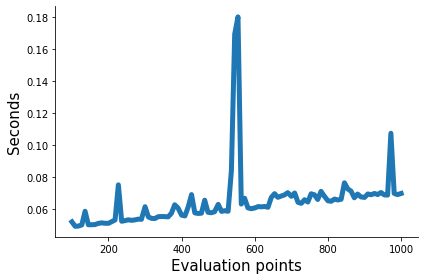

In [28]:
plot_computational_budget(grid, rslts)

We need to learn where to invest a limited computational budget. We focus on the following going forward:

* smoothing parameter for logit accept-reject simulator

* grid search across core parameters

### Smoothing parameter

We now show the shape of the likelihood function for alternative choices of the smoothing parameter $\tau$. There exists no closed-form solution for the choice probabilities, so these are simulated. Application of a basic accept-reject (AR) simulator poses the two challenges. First, there is the ocurrance of zero probability simulation for low probability events which causes problems for the evaluation of the log-likelihood. Second, the choice probabilities are not smooth in the parameters and instead are a step function. This is why McFadden (1989) introduces a class of smoothed AR simulators. The logit-smoothed AR simulator is the most popular one and also implemented in `respy`. The implementation requires to specify the smoothing parameter $\tau$. As $\tau \rightarrow 0$ the logit smoother approaches the original indicator function.

* McFadden, D. (1989). [A method of simulated moments for estimation of discrete response models without numerical integration](https://www.jstor.org/stable/1913621?seq=1#metadata_info_tab_contents). *Econometrica, 57*(5), 995-1026.

* Train, K. (2009). [Discrete choice methods with simulation](https://eml.berkeley.edu/books/train1201.pdf). Cambridge University Press, Cambridge.


In [29]:
rslts = dict()

for tau in [0.01, 0.001, 0.0001]:

    index = ("delta", "delta")
    
    options = options_base.copy()
    options["estimation_tau"] = tau

    crit_func = rp.get_crit_func(params_base, options, df)
    grid = np.linspace(0.948, 0.952, 20)
    
    fvals = list()
    for value in grid:
        params = params_base.copy()
        params.loc[index, "value"] = value
        fvals.append(crit_func(params))

    rslts[tau] = fvals - np.max(fvals)

Now we are ready to inspect the shape of the likelihood function.

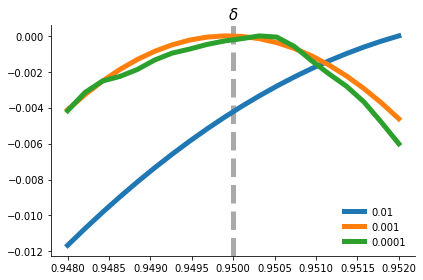

In [30]:
plot_smoothing_parameter(rslts, params_base, grid)

### Grid search

We can look at the interplay of several major numerical tuning parameters. We combine choices for `simulation_agents`, `solution_draws`, `estimation_draws`, and `tau` to see how the maximum of the likelihood function changes. 

In [31]:
df = pd.read_pickle("material/tuning.delta.pkl")
df.loc[((10000), slice(None)), :]

delta
agents draws tau                   
10000  100   1.000000e-02     0.952
             1.000000e-03  0.949684
             1.000000e-04  0.949684
             1.000000e-05  0.949684
             1.000000e-06  0.949684
             1.000000e-07  0.949684
       1000  1.000000e-02     0.952
             1.000000e-03  0.950316
             1.000000e-04  0.950105
             1.000000e-05  0.950105
             1.000000e-06  0.950105
             1.000000e-07  0.950105
       10000 1.000000e-02     0.952
             1.000000e-03  0.950316
             1.000000e-04  0.950105
             1.000000e-05  0.950105
             1.000000e-06  0.950105
             1.000000e-07  0.950105